2025-02-24 18:50:33,436 - INFO - Parkinson's data loaded successfully from pd.csv
/tmp/ipykernel_1565379/1128632428.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_df['dept'] = pd_df['dept'].replace({'2A': -1, '2B': -2})
/tmp/ipykernel_1565379/1128632428.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_df['dept'] = pd.to_numeric(pd_df['dept'], errors='coerce')
2025-02-24 18:50:33,439 - INFO - Searching for files matching pattern: BNVD_2023_VENTE//BNVD_TRACABILITE_20231023_VENTE_DPT_SUBSTANCE_

substance  annee  region  dept  Ntop     Npop   prev  \
0           2015       1   971  1500   377070  0.398   
1           2015       2   972  1000   355610  0.282   
2           2015       3   973   170   179400  0.094   
3           2015       4   974  1580   859530  0.183   
4           2015      11    75  6940  2071940  0.335   

substance  (e)-5-decen-1-yl acetate  (e,z)-2,13-octadecadienyl acetate  \
0                               NaN                                NaN   
1                               NaN                                NaN   
2                               NaN                                NaN   
3                               NaN                                NaN   
4                               NaN                                NaN   

substance  (e,z)-3,13-octadecadienyl acetate  \
0                                        NaN   
1                                        NaN   
2                                        NaN   
3                         

/home/anat/anaconda3/envs/AI/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/anat/anaconda3/envs/AI/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


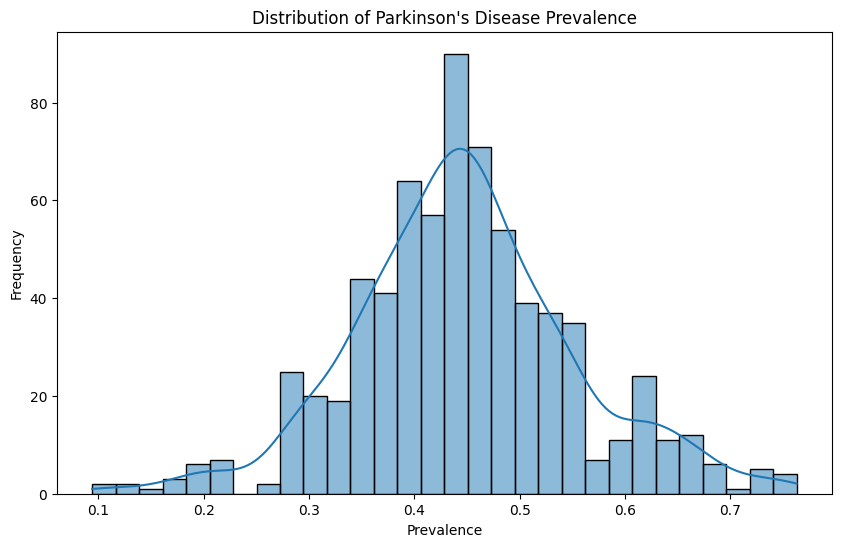

/home/anat/anaconda3/envs/AI/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/anat/anaconda3/envs/AI/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/anat/anaconda3/envs/AI/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/anat/anaconda3/envs/AI/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf 

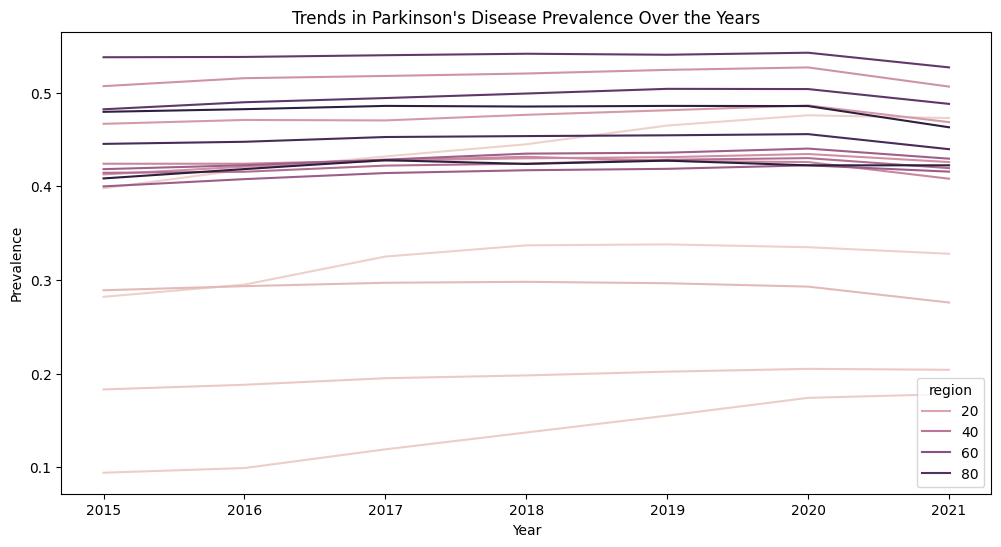

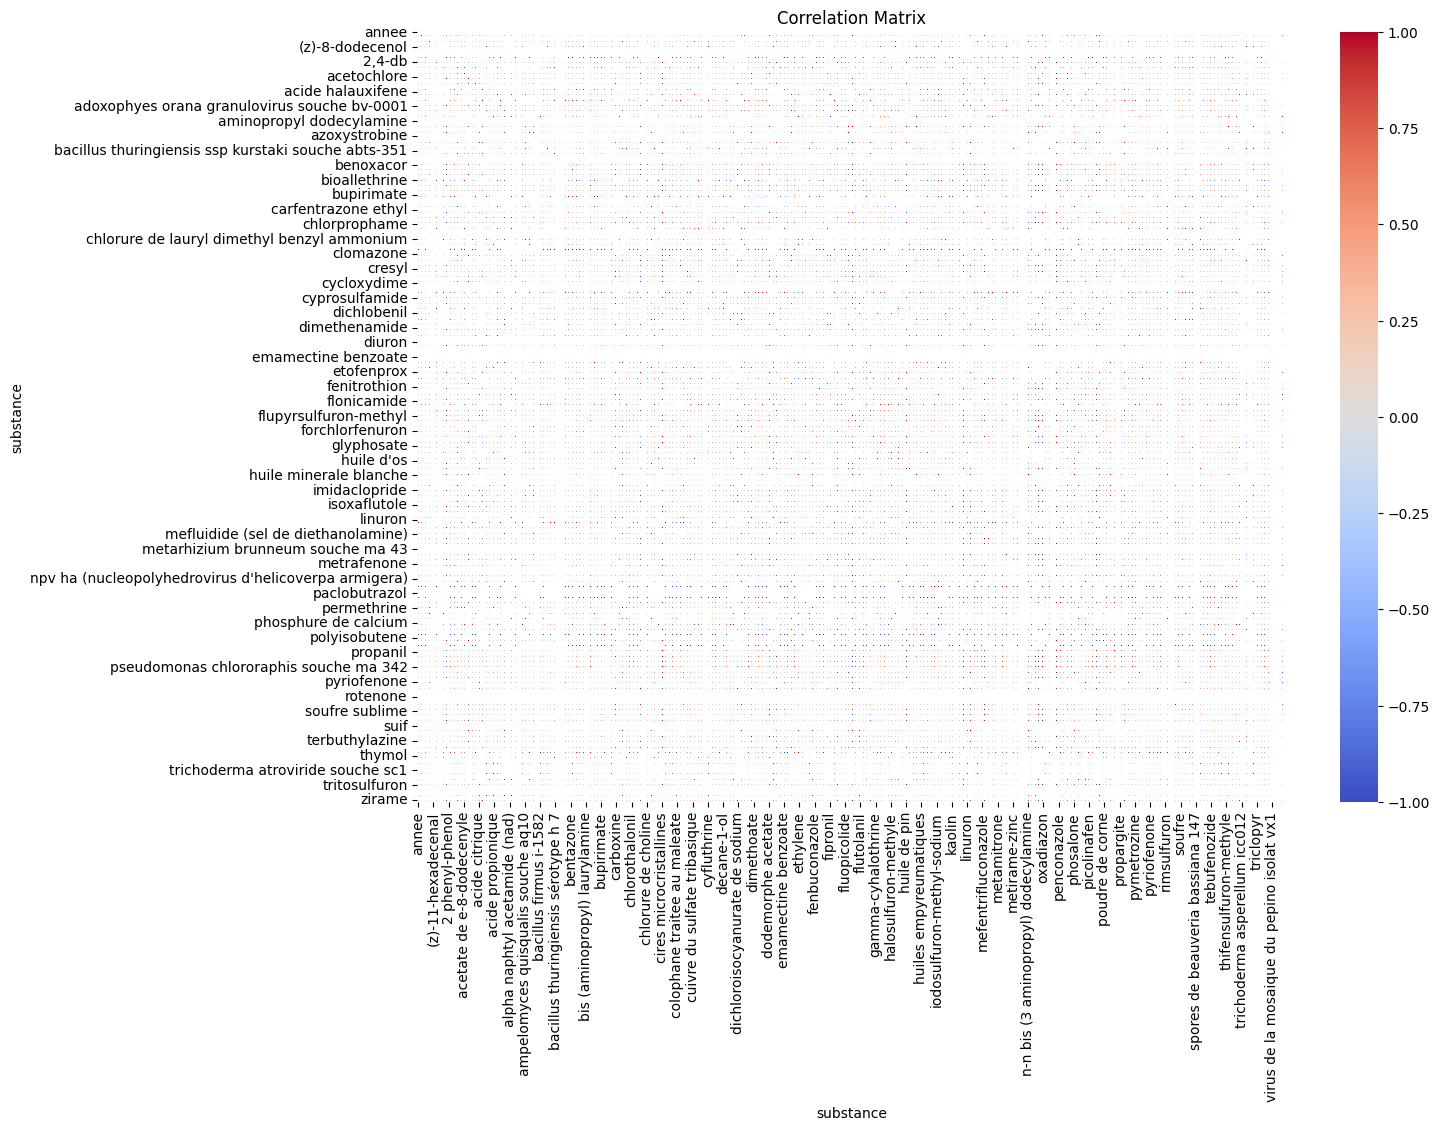

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import glob
from typing import List, Dict, Tuple

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


class DataMerger:
    """
    Merges Parkinson's disease prevalence data with pesticide sales data.
    """

    def __init__(self, pd_file_path: str, pesticides_dir: str, pd_delimiter: str = ';',
                 pesticides_delimiter: str = ';', start_year: int = 2015, end_year: int = 2021):
        self.pd_file_path = pd_file_path
        self.pesticides_dir = pesticides_dir
        self.pd_delimiter = pd_delimiter
        self.pesticides_delimiter = pesticides_delimiter
        self.start_year = start_year
        self.end_year = end_year
        self.merged_df = None

    def load_and_select_pd_data(self) -> pd.DataFrame:
        """Loads Parkinson's data, selects columns, handles Corsica, and data types."""
        try:
            df = pd.read_csv(self.pd_file_path, delimiter=self.pd_delimiter)
            logging.info(f"Parkinson's data loaded successfully from {self.pd_file_path}")
            df = df.drop(columns=['Unnamed: 0'], errors='ignore')
            selected_columns = ['annee', 'region', 'dept', 'Ntop', 'Npop', 'prev']
            pd_df = df[selected_columns]
            pd_df['dept'] = pd_df['dept'].replace({'2A': -1, '2B': -2})
            pd_df['dept'] = pd.to_numeric(pd_df['dept'], errors='coerce')
            pd_df = pd_df.astype({
                'annee': 'int16',
                'region': 'Int16',
                'dept': 'Int16',
                'Ntop': 'Int32',
                'Npop': 'Int32',
                'prev': 'float32'
            })
            return pd_df
        except (FileNotFoundError, pd.errors.ParserError, Exception) as e:
            logging.error(f"Error loading Parkinson's data: {e}")
            raise

    def load_and_select_pesticides_data(self) -> pd.DataFrame:
        """Loads and concatenates pesticide data."""
        all_pesticide_dfs = []
        for year in range(self.start_year, self.end_year + 1):
            file_pattern = f"{self.pesticides_dir}/BNVD_TRACABILITE_20231023_VENTE_DPT_SUBSTANCE_{year}.csv"
            logging.info(f"Searching for files matching pattern: {file_pattern}")
            files = glob.glob(file_pattern)
            if not files:
                logging.warning(f"No pesticide files found for year {year}")
                continue
            for file in files:
                try:
                    df = pd.read_csv(file, delimiter=self.pesticides_delimiter)
                    logging.info(f"Pesticide data loaded successfully from {file}")
                    df = df.drop(columns=['Unnamed: 0'], errors='ignore')
                    cols = ['annee', 'code_departement', 'substance', 'quantite_substance']
                    df = df[cols]
                    df['code_departement'] = df['code_departement'].replace({'2A': -1, '2B': -2})
                    df['code_departement'] = pd.to_numeric(df['code_departement'], errors='coerce')
                    df = df.astype({
                        'annee': 'int16',
                        'code_departement': 'Int16',
                        'substance': 'string',
                        'quantite_substance': 'float32'
                    })
                    all_pesticide_dfs.append(df)
                except (FileNotFoundError, pd.errors.ParserError, Exception) as e:
                    logging.error(f"Error loading pesticide data from {file}: {e}")
                    raise
        pesticides_df = pd.concat(all_pesticide_dfs, ignore_index=True)
        logging.info("Pesticide dataframes concatenated successfully.")
        return pesticides_df

    def merge_data(self, pd_df: pd.DataFrame, pesticides_df: pd.DataFrame) -> pd.DataFrame:
        """Merges Parkinson's and pesticide data."""
        merged_df = pd.merge(pd_df, pesticides_df, how='left', left_on=['annee', 'dept'],
                             right_on=['annee', 'code_departement'])
        logging.info("Dataframes merged successfully.")
        pivot_df = merged_df.pivot_table(index=['annee', 'region', 'dept', 'Ntop', 'Npop', 'prev'],
                                         columns='substance', values='quantite_substance', aggfunc='sum')
        final_df = pivot_df.reset_index()
        logging.info("Dataframe pivoted successfully.")
        self.merged_df = final_df
        return final_df

    def get_merged_df(self) -> pd.DataFrame:
        """Returns the merged DataFrame, loading and merging if necessary."""
        if self.merged_df is None:
            pd_df = self.load_and_select_pd_data()
            pesticides_df = self.load_and_select_pesticides_data()
            self.merged_df = self.merge_data(pd_df, pesticides_df)
        return self.merged_df

    def analyze_correlations(self, target_variable: str = 'prev') -> pd.Series:
        """Analyzes correlations."""
        if self.merged_df is None:
            self.get_merged_df()
        correlation_matrix = self.merged_df.corr(numeric_only=True)
        return correlation_matrix[target_variable].sort_values(ascending=False)

    def visualize_data(self, substance_column=None):
        """Visualizes data, handling 'region' correctly."""

        if self.merged_df is None:
            self.get_merged_df()

        plot_df = self.merged_df.copy()

        # Fill missing 'region' values and convert to standard int64
        plot_df['region'] = plot_df['region'].fillna(0).astype(int)  # The KEY CHANGE

        plt.figure(figsize=(10, 6))
        sns.histplot(plot_df['prev'], bins=30, kde=True)
        plt.title('Distribution of Parkinson\'s Disease Prevalence')
        plt.xlabel('Prevalence')
        plt.ylabel('Frequency')
        plt.show()

        if substance_column:
            plt.figure(figsize=(10, 6))
            sns.histplot(plot_df[substance_column].dropna(), bins=30, kde=True)
            plt.title(f'Distribution of {substance_column} Quantity')
            plt.xlabel('Quantity')
            plt.ylabel('Frequency')
            plt.show()

        plt.figure(figsize=(12, 6))
        sns.lineplot(x='annee', y='prev', data=plot_df, hue='region', errorbar=None)
        plt.title('Trends in Parkinson\'s Disease Prevalence Over the Years')
        plt.xlabel('Year')
        plt.ylabel('Prevalence')
        plt.show()

        correlation_matrix = plot_df.corr(numeric_only=True)
        plt.figure(figsize=(14, 10))
        sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f", linewidths=.5)
        plt.title('Correlation Matrix')
        plt.show()
# Example Usage:

if __name__ == "__main__":
    pd_file = 'pd.csv'  # Your Parkinson's data file
    pesticides_directory = 'BNVD_2023_VENTE/'  # Replace with the actual directory
    # Create a DataMerger instance, specifying the directory
    merger = DataMerger(pd_file, pesticides_directory)
    final_dataframe = merger.get_merged_df()
    print(final_dataframe.head())

    correlations = merger.analyze_correlations()
    print(correlations)
    merger.visualize_data()

In [4]:
correlations.head()

substance
cires de petrole                      1.0
paraffine                             1.0
mefluidide (sel de diethanolamine)    1.0
haloxyfop-r                           1.0
prev                                  1.0
Name: prev, dtype: float64

__main__.DataMerger